In [33]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor, Compose, Resize
from torchvision.datasets.mnist import MNIST

np.random.seed(42)
torch.manual_seed(42)


This notebook will follow the following architecture. We are going to use the MNIST dataset for that, which all images have 28x28.

The main objective of a ViT (Visual Transformers) is to separate an image into patches, flatten it, and extract the position of each patch, and use that as input to the Encoder.


The code was explained, extracted and adapted from https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

![convert notebook to web app](https://miro.medium.com/v2/resize:fit:720/format:webp/1*tA7xE2dQA_dfzA0Bub5TVw.png)


# Lets create the patching function

In [14]:
def patchify(images: torch.Tensor(), n_patches: int) -> torch.Tensor():

    """
    Parameters:
    images: the dataset of images. Must be a tensor

    n_patches: the number of patches to be extracted from each image

    Returns:

    The patches for each image
    """

    n, c, h, w = images.shape # number of images, channels, height and width

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)

    # For example, we want that the image with a size of 28x28 be patched with 7 patches (7x7),
    # each patch will have 4x4, and, after flatted, will have 1x16
    # So, this can be given to us with the operation above: (number of images, 49, 16)
    # So, we are going to have n images, with 49 patches, each one with 1 row and 16 columns

    patch_size = h // n_patches 

    # Well, the patchsize is going to be that operation. That means, a image with 28x28,
    # that is going to be patched with 7 patches (7x7), each path will have 4x4

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches


## This image ilustrates the process above:

![alternative text](https://miro.medium.com/v2/resize:fit:640/format:webp/1*CFbOxEuvo-Pgq7ETIrt0Eg.png)


Now we can define our first part of our class, processing the files to be used in the input of the ViT

In [12]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (Channels, Height, Width)
    self.n_patches = n_patches 

    # We need to assert that the number of patches asked needs to be matching with the input shape. 
    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    return patches


Now we need to apply our first linear transformation of our input. So, in our case, we are going from a vector with length of 16 to 8

In [ ]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (Channels, Height, Width)
    self.n_patches = n_patches

    # We need to assert that the number of patches asked needs to be matching with the input shape. 
    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches) # ((28/7), (28/7)) -> (4,4)

    # 1) Linear mapper
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1]) # (1*4*4) -> (16)
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d) # linear transformation from 16 to 8, each flatten vector will be linear transformed from 16 to 8

    
  def forward(self, images):
    patches = patchify(images, self.n_patches) # patching the images
    tokens = self.linear_mapper(patches) # linear transformation
    return tokens


Now, the next step is to add the order of the images as information to the transformer. This will help in the next step to the model understand where each patch would be placed in the original image.

In [ ]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (Channels, Height, Width)
    self.n_patches = n_patches

    # We need to assert that the number of patches asked needs to be matching with the input shape. 
    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches) # ((28/7), (28/7)) -> (4,4)

    # 1) Linear mapper
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1]) # (1*4*4) -> (16)
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d) # linear transformation from 16 to 8, each flatten vector will be linear transformed from 16 to 8

    
  def forward(self, images):
    patches = patchify(images, self.n_patches) # patching the images
    tokens = self.linear_mapper(patches) # linear transformation

    # Adding the order of the patches
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

    return tokens


Well, once we already have the position of each patch, we need to apply the positional encoding. This will generate embedding of the positions of each image. 


Well, transformers were proposed to natural language models. So, every encoding process that we are applying here, was developed, previously, in NLP applications. But, we are replicating it in images.


So, lets explain looking to NLP how the positional encodding works. Think that, in that example, the input of the model to be trained are actually sentences. Each sentence have a number of words. Their position in the sentence will be mapped. So, will be applied the positional encodding. The positional encodding look at all the words in the sentence and generate encoddings to each of them, assigning weights.
But, now, we have that being applied to the flatted patches of the images. 


The positional embeddings are obtained with the following equation in the image below:

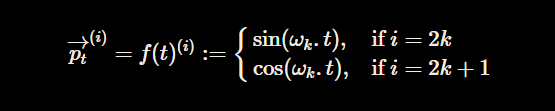

In [13]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

Then, the positional embeddings are summed with the positions, as itselves.

In [ ]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

    # 3) Positional embedding
    self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))
    self.pos_embed.requires_grad = False

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)

    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

    # Adding positional embedding
    pos_embed = self.pos_embed.repeat(n, 1, 1)
    out = tokens + pos_embed
    return out


In general, in this step, this is performed (from the video https://www.youtube.com/watch?v=4Bdc55j80l8):

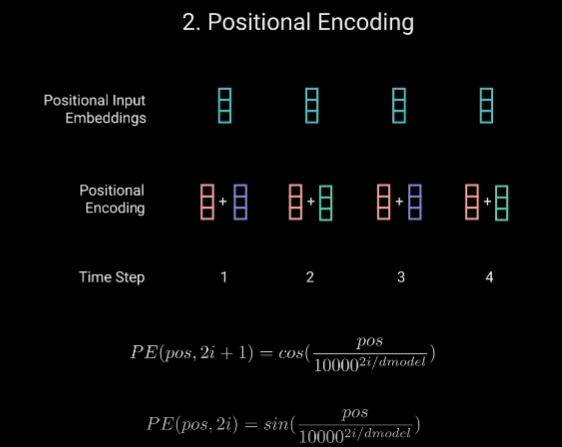

Now we are going to the Multi-head Self Attention.


Self attention allows to each patch to be associated in all the other patches in the input. So, each part of the image are going to be associated to all the others.


To that, we fit the input into 3 linear connection layers, to get what we call query, key and value vectors. 

The queries and keys are going to a dot product matrix to produce a score matrix. The score matrix determines how much of focus should a patch be put in another patches. So, each patch will have a score that correspond to another patches in a timestamp. The higher the score, the more the focus. Then the scores are divided by the square root of the dimension of the queries and the keys. Your are normalizing the matrix, in general. And then you apply the Softmax, which gives you the probabilites between 0 and 1. This allows to the model be more confident of which patch to be atent to. Then you get these attentions weights and multiply by your value vector, to get an output. The higher the softmax scores, will make the value of the patches that the model learned are more important. Then you fit this output to a linear layer to process. 

To make this in multi-headed attention, you need to split the query, key and value into eighenvectors before applying self-attetion. Then, we are going to divide into 2 self-attentions, called heads. Each self attention produces an output that is going to be concatenated into a single vector before going to a final linear layer. 

The images below, from the video https://www.youtube.com/watch?v=4Bdc55j80l8 explains that


Each key, query and value:\
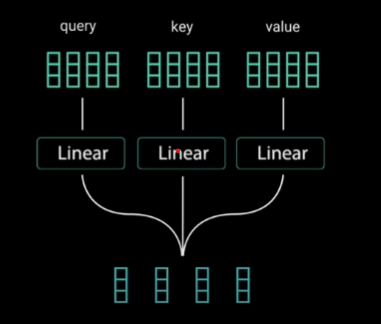

Dot product between them:\
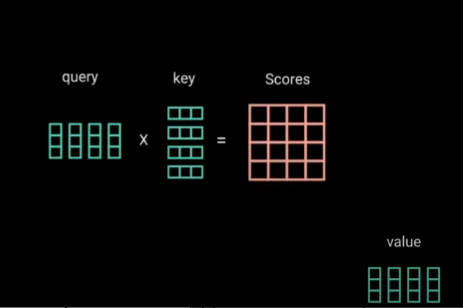

Score values:\
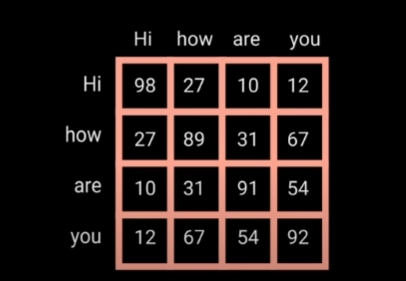

Normalization:\
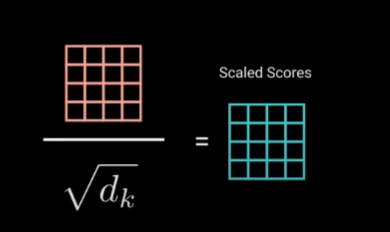

Softmax:\
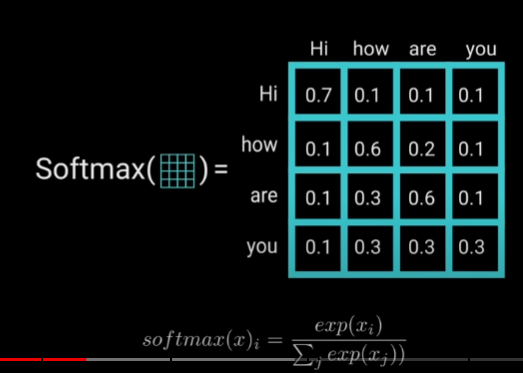

Product with the values: \
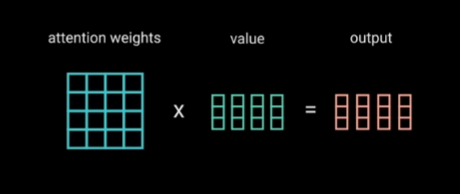

Multi-head attention: \
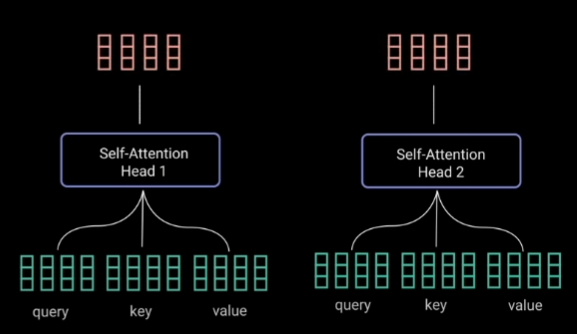

Linear transformation of the output: \
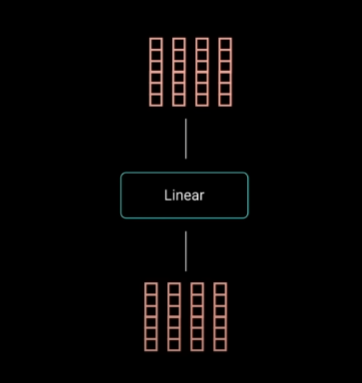

In [16]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])


Then we apply the residual connection. A residual connection consists in just adding the original input to the result of some computation. 

In [15]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        return out


Then, we add the feed forward at the end, with GELU activaction function. 



In [17]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out


In [18]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        return out


And, then, we get the encodded outputs, and apply the mlp to get the final prediction

In [30]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) # Map to output dimension, output category distribution


In [31]:
def main():
    # Loading data
    transform = Compose[ToTensor(), Resize((28,28)),
]

    train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
    test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Defining model and training options
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    N_EPOCHS = 5
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")
